In [1]:
# Import libraries
import yaml
import numpy as np
from typing import List

from utils import torch_seed
# from models import CoordAtt
# from models import CoordAttwSE
from focal_loss import FocalLoss
from timm import create_model
from data import create_dataloader, create_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Setting the default seed
torch_seed(42)

In [3]:
# Setting the configuration
object_name = 'capsule'
config = yaml.load(open(f'./configs/{object_name}.yaml', 'r'), Loader=yaml.FullLoader)
config

{'EXP_NAME': 'MemSeg-Original',
 'SEED': 42,
 'DATASET': {'datadir': './datasets/MVTec',
  'texture_source_dir': './datasets/dtd/images',
  'target': 'capsule',
  'resize': (256, 256),
  'structure_grid_size': 8,
  'transparency_range': [0.15, 1.0],
  'perlin_scale': 6,
  'min_perlin_scale': 0,
  'perlin_noise_threshold': 0.5},
 'DATALOADER': {'batch_size': 8, 'num_workers': 4},
 'MEMORYBANK': {'nb_memory_sample': 30},
 'MODEL': {'feature_extractor_name': 'resnet18'},
 'TRAIN': {'batch_size': 8,
  'num_training_steps': 3000,
  'l1_weight': 0.6,
  'focal_weight': 0.4,
  'focal_alpha': None,
  'focal_gamma': 4,
  'use_wandb': True},
 'OPTIMIZER': {'lr': 0.003, 'weight_decay': 0.0005},
 'SCHEDULER': {'min_lr': 0.0001, 'warmup_ratio': 0.1, 'use_scheduler': True},
 'LOG': {'log_interval': 1, 'eval_interval': 100},
 'RESULT': {'savedir': './saved_model/original'}}

In [4]:
# Loading Dataset
trainset = create_dataset(
    datadir                = config['DATASET']['datadir'],
    target                 = config['DATASET']['target'], 
    train                  = True,
    resize                 = config['DATASET']['resize'],
    texture_source_dir     = config['DATASET']['texture_source_dir'],
    structure_grid_size    = config['DATASET']['structure_grid_size'],
    transparency_range     = config['DATASET']['transparency_range'],
    perlin_scale           = config['DATASET']['perlin_scale'], 
    min_perlin_scale       = config['DATASET']['min_perlin_scale'], 
    perlin_noise_threshold = config['DATASET']['perlin_noise_threshold']
)

In [5]:
# Creating the dataloader object
dataloader = create_dataloader(
    dataset     = trainset,
    train       = True,
    batch_size  = config['DATALOADER']['batch_size'],
    num_workers = config['DATALOADER']['num_workers']
)

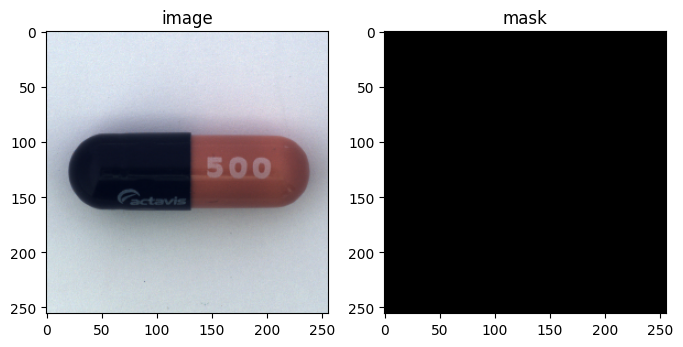

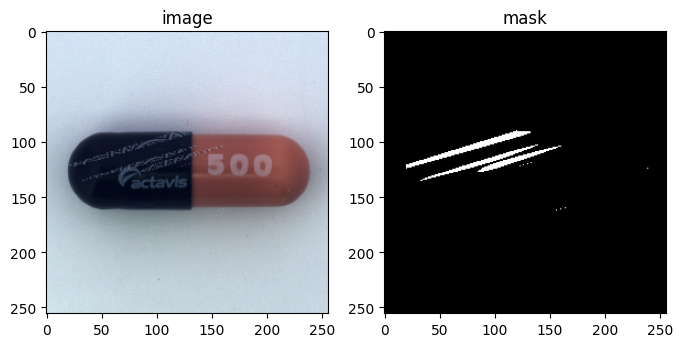

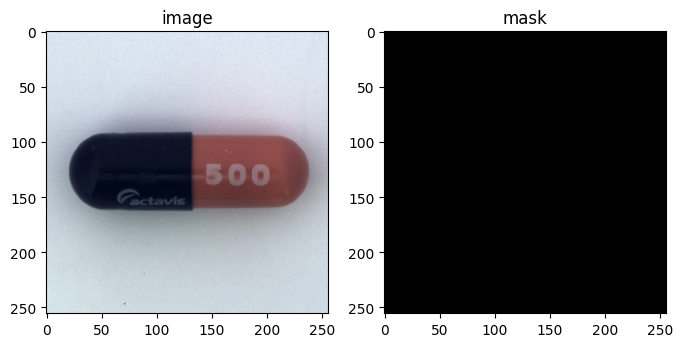

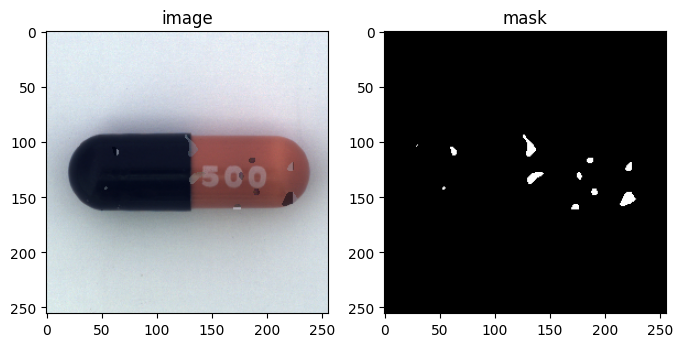

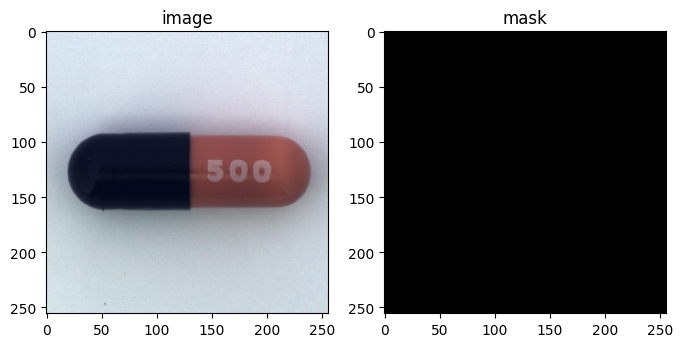

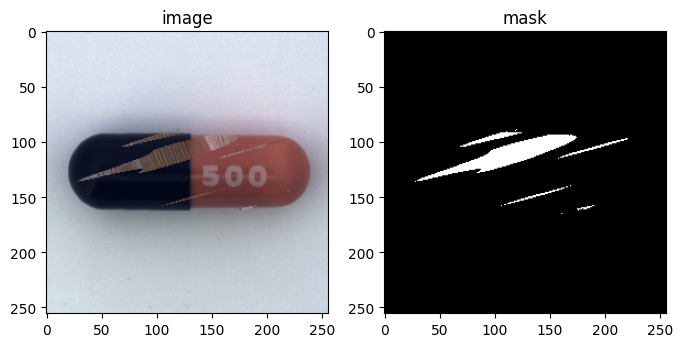

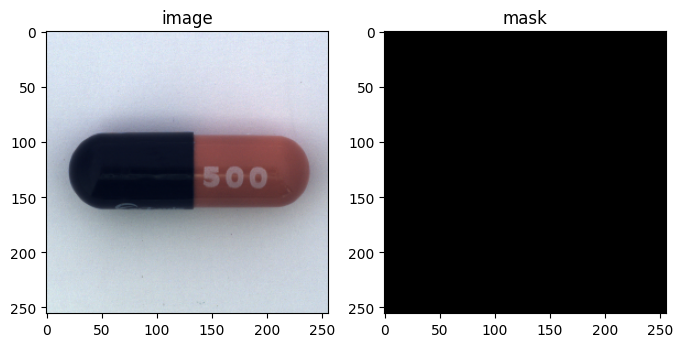

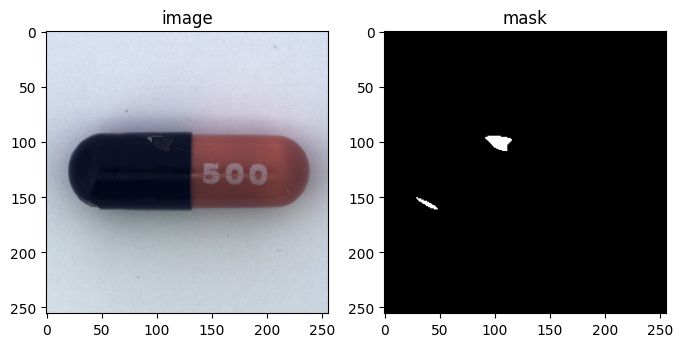

In [6]:
def minmax_scaling(img):
    return (((img - img.min()) / (img.max() - img.min())) * 255).to(torch.uint8)

for i in range(8):
    img, mask, target = trainset[i]
    fig, ax = plt.subplots(1, 2, figsize=(8, 10))
    ax[0].imshow(minmax_scaling(img.permute(1, 2, 0)))
    ax[0].set_title('image')
    ax[1].imshow(mask*255, cmap='gray')
    ax[1].set_title('mask')

# Model Overview
![MODEL ARCHITECTURE](viz/model_architecture.png)

## **I. Feature Extraction**

In [7]:
# Feature Extraction
inputs, masks, targets = next(iter(dataloader))
inputs.shape, masks.shape

(torch.Size([8, 3, 256, 256]), torch.Size([8, 256, 256]))

In [8]:
encoder = create_model(
    'resnet18',
    pretrained=True,
    features_only=True,
)

features = encoder(inputs)
f_in, f_ii, f_out = features[0], features[1:-1], features[-1]

for i, feature in enumerate(features):
    print(f'Layer {i}', '---', feature.size())

Layer 0 --- torch.Size([8, 64, 128, 128])
Layer 1 --- torch.Size([8, 64, 64, 64])
Layer 2 --- torch.Size([8, 128, 32, 32])
Layer 3 --- torch.Size([8, 256, 16, 16])
Layer 4 --- torch.Size([8, 512, 8, 8])


In [9]:
for layer in ['layer1','layer2','layer3']:
    for p in encoder[layer].parameters():
        p.requires_grad = False


## **II. Memory Module**

$$DI = \bigcup_{i=1}^{N}||MI_i - II||_2$$
$$DI^*= \text{argmin}_{DI_i \in DI} \sum_{x \in DI_i} x$$

In [10]:
# Memory Module
class MemoryBank:
    def __init__(self, normal_dataset, nb_memory_sample: int=30, device='cpu'):
        # Normal Dataset
        self.normal_dataset = normal_dataset

        # Number of samples in memory bank
        self.nb_memory_sample = nb_memory_sample

        self.device = device

        # Memory Bank
        self.memory_info = {}

    def update(self, encoder):
        encoder.eval()

        # Define samples indices
        sample_indices = np.arange(len(self.normal_dataset))
        np.random.shuffle(sample_indices)
        
        # Extract features and save features into memory bank
        with torch.no_grad():
            for i in range(self.nb_memory_sample):
                # Select image
                input_normal,  _, _ = self.normal_dataset[sample_indices[i]]
                input_normal        = input_normal.to(self.device)

                # Extract features
                features = encoder(input_normal.unsqueeze(0))
                ()
                # Save features into memory bank
                for i, feature in enumerate(features[1:-1]):
                    if f'level{i}' not in self.memory_info.keys():
                        self.memory_info[f'level{i}'] = feature
                    else:
                        self.memory_info[f'level{i}'] = torch.cat([self.memory_info[f'level{i}'], feature], dim=0)

    def _calc_diff(self, features: List[torch.Tensor]) -> torch.Tensor:
        # Batch size X the number of samples saved in memory
        diff_bank = torch.zeros(features[0].size(0), self.nb_memory_sample)

        for i, level in enumerate(self.memory_info.keys()):
            for batch_idx, batch_feature in enumerate(features[i]):
                diff = F.mse_loss(
                    input=torch.repeat_interleave(batch_feature.unsqueeze(0), repeats=self.nb_memory_sample, dim=0),
                    target=self.memory_info[level],
                    reduction='none'
                ).mean(dim=[1,2,3])
                # Sum Loss
                diff_bank[batch_idx] += diff

        return diff_bank

    def select(self, features: List[torch.Tensor])->torch.Tensor:
        # Calculate the difference between features and normal features of memory bank
        diff_bank = self._calc_diff(features)

        # Concatenate features with minimum difference features of memory bank
        for i, level in enumerate(self.memory_info.keys()):
            selected_features = torch.index_select(self.memory_info[level], dim=0, index=diff_bank.argmin(dim=1))
            diff_features = F.mse_loss(selected_features, features[i], reduction='none')
            features[i] = torch.cat([features[i], diff_features], dim=1)
        return features


In [11]:
memory_bank = MemoryBank(
    normal_dataset = trainset,
    nb_memory_sample = config['MEMORYBANK']['nb_memory_sample']
)

In [12]:
memory_bank.update(encoder=encoder)

In [13]:
for k, v in memory_bank.memory_info.items():
    print(f'MI {k}: {v.size()}')

MI level0: torch.Size([30, 64, 64, 64])
MI level1: torch.Size([30, 128, 32, 32])
MI level2: torch.Size([30, 256, 16, 16])


In [14]:
concat_features = memory_bank.select(features=f_ii)

In [15]:
for i, f in enumerate(concat_features):
    print(f'CI_{i}: {f.size()}')

CI_0: torch.Size([8, 128, 64, 64])
CI_1: torch.Size([8, 256, 32, 32])
CI_2: torch.Size([8, 512, 16, 16])


## **III. Multi-scale Feature Fusion Module**
![Multi-scale Feature Fusion Module](viz/multi-scale_feature_fusion.png)

### **1. Coordinate Attention**

![CoordAtt](viz/coord-attention.png)

In [16]:
class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6

class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)

class CoordAtt(nn.Module):
    def __init__(self, in_channels, out_channels, reduction_ratio=32):
        super(CoordAtt, self).__init__()
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        
        mip = max(8, in_channels // reduction_ratio)

        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()

        self.conv_h = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        identify = x
        N, C, H, W = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)  # N,C,W,H

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)

        x_h, x_w = torch.split(y, [H, W], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()

        out = identify * a_w * a_h

        return out


class SELayer(nn.Module):
    def __init__(self, channel, reduction=32):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class CoordAttwSE(nn.Module):
    def __init__(self, in_channels, out_channels, reduction_ratio=32):
        super(CoordAttwSE, self).__init__()
        self.se_block = SELayer(channel=in_channels)
        self.pool_h = nn.AdaptiveAvgPool2d((None, 1))
        self.pool_w = nn.AdaptiveAvgPool2d((1, None))
        
        mip = max(8, in_channels // reduction_ratio)

        self.conv1 = nn.Conv2d(in_channels, mip, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(mip)
        self.act = h_swish()

        self.conv_h = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)
        self.conv_w = nn.Conv2d(mip, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        se_att = self.se_block(x)
        identify = x
        N, C, H, W = x.size()
        x_h = self.pool_h(x)
        x_w = self.pool_w(x).permute(0, 1, 3, 2)  # N,C,W,H

        y = torch.cat([x_h, x_w], dim=2)
        y = self.conv1(y)
        y = self.bn1(y)
        y = self.act(y)

        x_h, x_w = torch.split(y, [H, W], dim=2)
        x_w = x_w.permute(0, 1, 3, 2)

        a_h = self.conv_h(x_h).sigmoid()
        a_w = self.conv_w(x_w).sigmoid()

        out = identify * a_w * a_h
        out *= se_att

        return out

### **2. Multi-scale Feature Fusion Block**

In [17]:
class MSFFBlock(nn.Module):
    def __init__(self, in_channel):
        super(MSFFBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, in_channel, kernel_size=3, stride=1, padding=1)
        self.attn  = CoordAtt(in_channel, in_channel)
        # self.attn = CoordAttwSE(in_channel, in_channel)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channel, in_channel // 2, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channel // 2, in_channel // 2, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        x_conv = self.conv1(x)
        x_att = self.attn(x)
        
        x = x_conv * x_att 
        x = self.conv2(x)
        return x

    
class MSFF(nn.Module):
    """
    Implementation of `MS-FFN <https://arxiv.org/pdf/2205.00908.pdf>
    Multi-scale Feature Fusion Module
    """
    def __init__(self):
        super(MSFF, self).__init__()
        self.block3 = MSFFBlock(128)
        self.block2 = MSFFBlock(256)
        self.block1 = MSFFBlock(512)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.upconv32 = nn.Sequential(
            nn.Upsample(scale_factor=1/2, mode='bilinear', align_corners=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        )
        self.upconv21 = nn.Sequential(
            nn.Upsample(scale_factor=1/2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, features):
        """
        Arguments:
            features  (List)  : [ci3, ci2, ci1]
            ci1       (Tensor): an [N, 512, 16, 16]
            ci2       (Tensor): an [N, 256, 32, 32]
            ci3       (Tensor): an [N, 128, 64, 64]
        """
        ci3, ci2, ci1 = features
        
        # MSFF Module
        ci1_k = self.block1(ci1)      # [N, 256, 16, 16]
        ci2_k = self.block2(ci2)      # [N, 128, 32, 32]
        ci3_k = self.block3(ci3)      # [N, 64, 64, 64]

        ci2_sigma = ci2_k + self.upconv32(ci3_k)        # Element-wise summation
        ci1_sigma = ci1_k + self.upconv21(ci2_sigma)    # Element-wise summation 

        # Spatial Attention 
        m1 = ci1[:, :, ...].mean(dim=1, keepdim=True)                       # Mask M1
        m2 = ci2[:, :, ...].mean(dim=1, keepdim=True) * self.upsample(m1)   # Mask M2
        m3 = ci3[:, :, ...].mean(dim=1, keepdim=True) * self.upsample(m2)   # Mask M3

        ci1_out = ci1_sigma * m1
        ci2_out = ci2_sigma * m2
        ci3_out = ci3_k * m3
        
        return [ci3_out, ci2_out, ci1_out]

In [18]:
msff_module = MSFF()

In [19]:
msff_outputs = msff_module(features=concat_features)
for i, feature in enumerate(msff_outputs):
    print(f'level{i+1}: {feature.size()}')


level1: torch.Size([8, 64, 64, 64])
level2: torch.Size([8, 128, 32, 32])
level3: torch.Size([8, 256, 16, 16])


### **3. Spatial Attention**

$$M_3 = \frac{1}{C_3} \sum_{i=1}^{C_3} DI_{3i}^{*}$$
$$M_2= \frac{1}{C_2} \sum_{i=1}^{C_2} DI_{2i}^{*} ⊙ M_3^U$$
$$M_1= \frac{1}{C_1} \sum_{i=1}^{C_1} DI_{1i}^{*} ⊙ M_2^U$$

In [20]:
upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

m3 = concat_features[2][:,:,...].mean(dim=1, keepdim=True).detach().cpu()
m2 = concat_features[1][:,:,...].mean(dim=1, keepdim=True).detach().cpu() * upsample(m3)
m1 = concat_features[0][:,:,...].mean(dim=1, keepdim=True).detach().cpu() * upsample(m2)

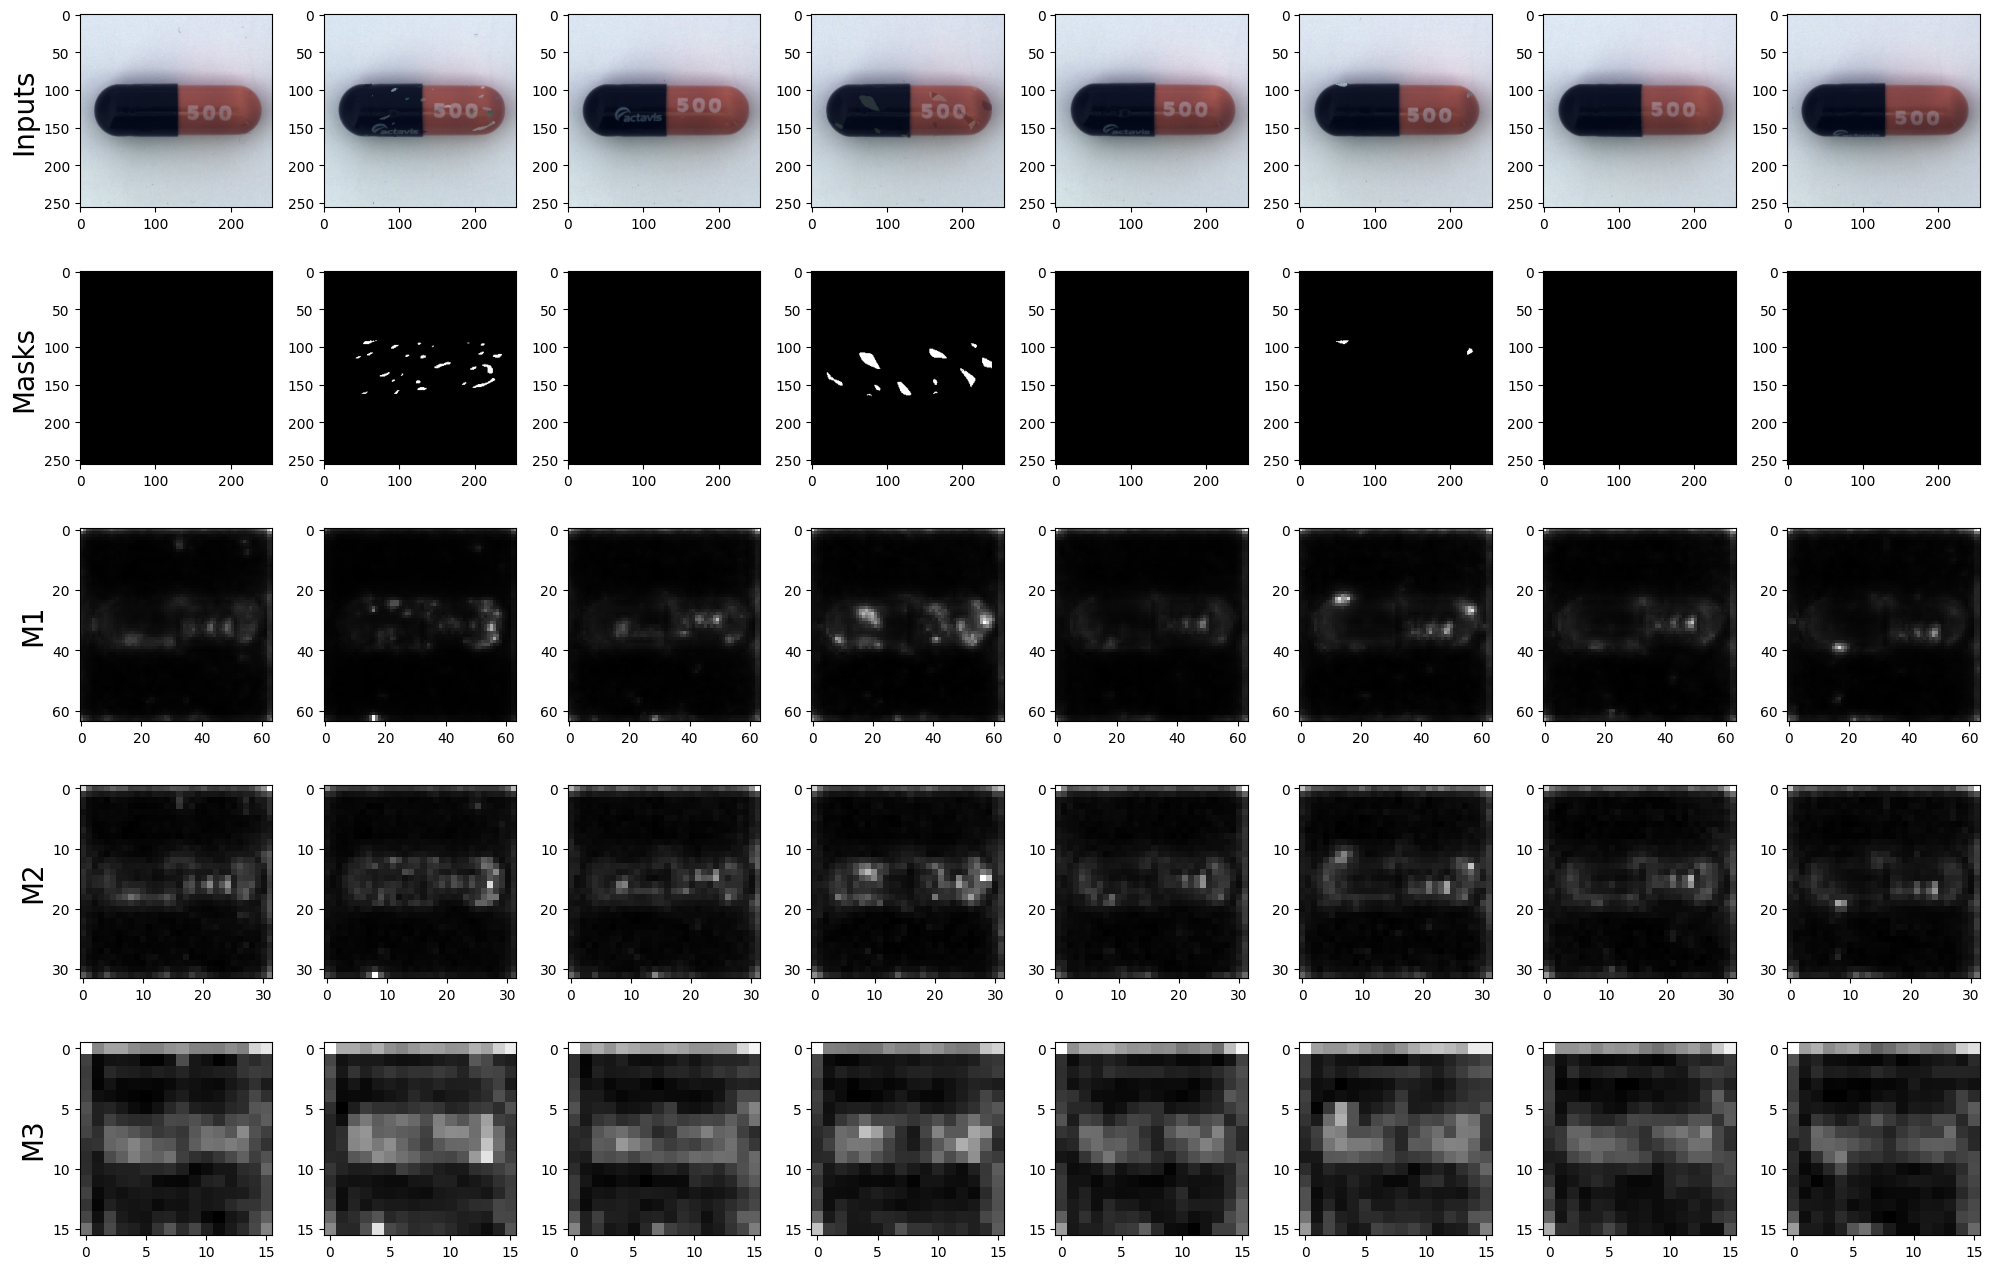

In [21]:
bs = inputs.size(0)
fig, ax = plt.subplots(5, bs, figsize=(20,13))

for i in range(bs):
    ax[0, i%bs].imshow(minmax_scaling(inputs[i].permute(1,2,0)))
    ax[1, i%bs].imshow(masks[i], cmap='gray')
    ax[2, i%bs].imshow(m1[i][0], cmap='gray')
    ax[3, i%bs].imshow(m2[i][0], cmap='gray')
    ax[4, i%bs].imshow(m3[i][0], cmap='gray')
    
    if i == 0:
        titles = ['Inputs','Masks','M1','M2','M3']
        for i in range(5):
            ax[i, 0].set_ylabel(titles[i], size=20)
plt.tight_layout()

## **IV. Decoder**
![Decoder](viz/model_architecture.png)

In [22]:
class UpConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConvBlock, self).__init__()
        self.blk = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )

    def forward(self, x):
        return self.blk(x)


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv = nn.Conv2d(64, 48, kernel_size=3, stride=1, padding=1)

        self.upconv3 = UpConvBlock(512, 256)
        self.upconv2 = UpConvBlock(512, 128)
        self.upconv1 = UpConvBlock(256, 64)
        self.upconv0 = UpConvBlock(128, 48)
        self.upconv2mask = UpConvBlock(96, 48)

        self.final_conv = nn.Conv2d(48, 2, kernel_size=3, stride=1, padding=1)

    def forward(self, encoder_output, concat_features):
        # concat_features = [level0, level1, level2, level3]
        f0, f1, f2, f3 = concat_features
        
        # 512 x 8 x 8 -> 512 x 16 x 16
        x_up3 = self.upconv3(encoder_output)
        x_up3 = torch.cat([x_up3, f3], dim=1)  

        # 512 x 16 x 16 -> 256 x 32 x 32
        x_up2 = self.upconv2(x_up3)
        x_up2 = torch.cat([x_up2, f2], dim=1)  

        # 256 x 32 x 32 -> 128 x 64 x 64
        x_up1 = self.upconv1(x_up2)
        x_up1 = torch.cat([x_up1, f1], dim=1)  

        # 128 x 64 x 64 -> 96 x 128 x 128
        x_up0 = self.upconv0(x_up1)
        f0 = self.conv(f0)
        x_up2mask = torch.cat([x_up0, f0], dim=1)  

        # 96 x 128 x 128 -> 48 x 256 x 256
        x_mask = self.upconv2mask(x_up2mask)  
        
        # 48 x 256 x 256 -> 1 x 256 x 256
        x_mask = self.final_conv(x_mask)  
        
        return x_mask


In [23]:
decoder = Decoder()
predicted_masks = decoder(encoder_output=f_out, concat_features=[f_in]+msff_outputs)

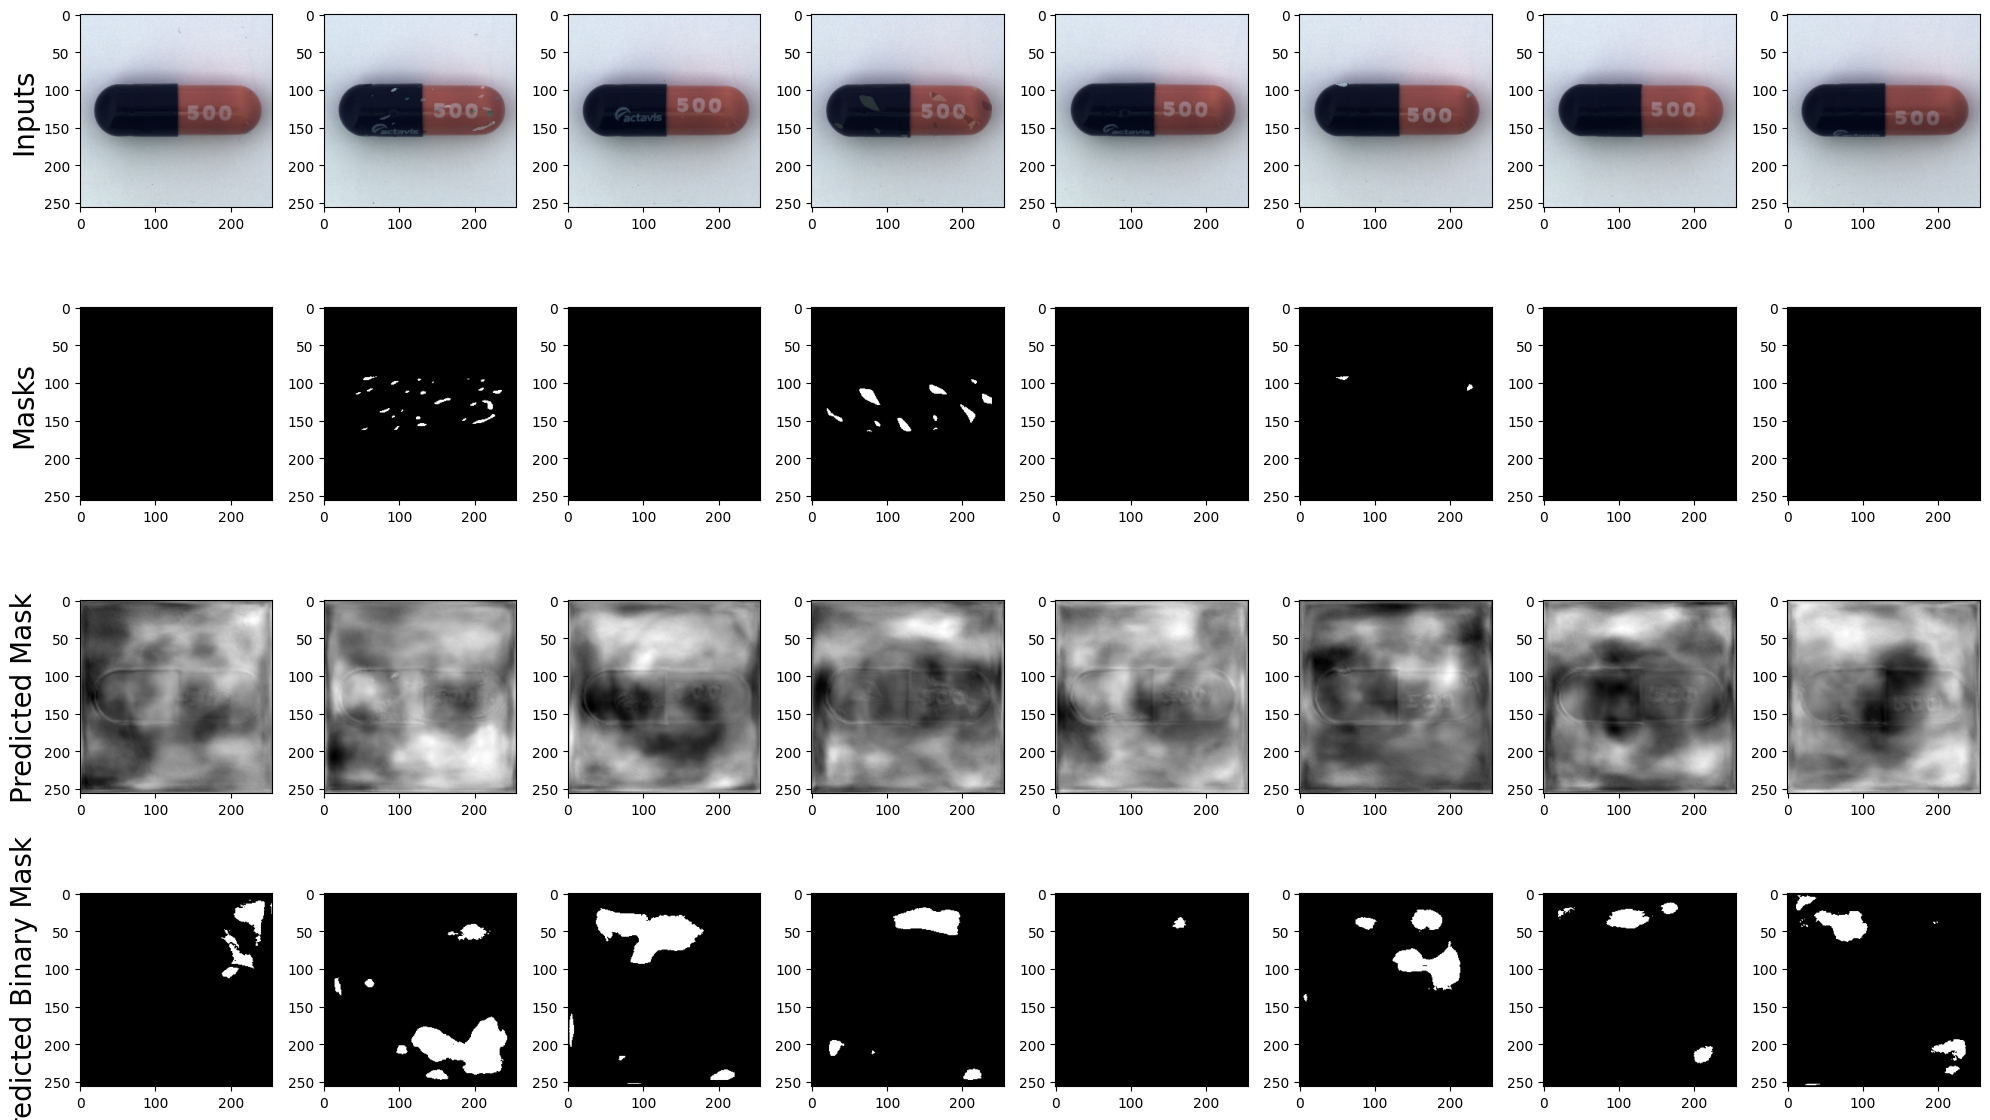

In [24]:
bs = inputs.size(0)
fig, ax = plt.subplots(4, bs, figsize=(20, 12))

threshold = 0.8

for i in range(bs):
    ax[0, i%bs].imshow(minmax_scaling(inputs[i].permute(1, 2, 0)))
    ax[1, i%bs].imshow(masks[i], cmap='gray')
    ax[2, i%bs].imshow(predicted_masks[i][0].detach(), cmap='gray')
    ax[3, i%bs].imshow((predicted_masks[i][0].detach() > threshold).to(torch.uint8), cmap='gray')
    
    if i == 0:
        titles = ['Inputs','Masks','Predicted Mask', 'Predicted Binary Mask']
        for i in range(4):
            ax[i, 0].set_ylabel(titles[i], size=20)
plt.tight_layout()

## MemSeg

In [25]:
class MemSeg(nn.Module):
    def __init__(self, memory_module, encoder):
        super(MemSeg, self).__init__()
        self.encoder = encoder
        self.memory_module = memory_module
        self.msff = MSFF()
        self.decoder = Decoder()

    def forward(self, inputs):
        features = self.encoder(inputs)
        f_in = features[0]
        f_out = features[-1]
        f_ii = features[1:-1]

        # Extracting concatenated information (CI)
        concatenated_features = self.memory_module.select(features=f_ii)
        """
        concatenated_features[0].shape - Tensor [N, 128, 64, 64]
        concatenated_features[1].shape - Tensor [N, 256, 32, 32]
        concatenated_features[2].shape - Tensor [N, 512, 16, 16]
        """

        # Multi-scale Feature Fusion (MSFF) Module
        msff_features = self.msff(features=concatenated_features)

        # Decoding Module
        predicted_mask = self.decoder(
            encoder_output=f_out,
            concat_features=[f_in] + msff_features
        )

        return predicted_mask

In [26]:
model = MemSeg(memory_module=memory_bank, encoder=encoder)
outputs = model(inputs)
outputs.size()

torch.Size([8, 2, 256, 256])

## **V. Loss Function**

$$L_{l1} = ||S - \hat{S}||_1$$
$$L_f = -\alpha_t(1-p_t)^\gamma \log(p_t)$$
$$L_all = \lambda_{l1}L_{l1} + \lambda_{f}L_{f}$$

In [27]:
l1_criterion = nn.L1Loss()
f_criterion = FocalLoss(gamma=config['TRAIN']['focal_gamma'], alpha=config['TRAIN']['focal_alpha'])

l1_loss = l1_criterion(predicted_masks[:,1,:], masks)
focal_loss = f_criterion(predicted_masks, masks)

print('L1 loss: ', l1_loss.item())
print('focal loss: ', focal_loss.item())

L1 loss:  0.3970858156681061
focal loss:  0.11475371569395065


In [28]:
loss = config['TRAIN']['l1_weight'] * l1_loss + config['TRAIN']['focal_weight'] * focal_loss
print('total loss: ',loss.item())

total loss:  0.2841529846191406


## **VI. Metrics**

In [29]:
from anomalib.utils.metrics import AUPRO, AUROC

In [30]:
auroc_image_metric = AUROC(num_classes=1, pos_label=1)
auroc_pixel_metric = AUROC(num_classes=1, pos_label=1)
aupro_pixel_metric = AUPRO()

In [31]:
predicted_anomaly_score = torch.topk(torch.flatten(predicted_masks[:,1,:], start_dim=1), 100)[0].mean(dim=1)

auroc_image_metric.update(
    preds = predicted_anomaly_score, 
    target = targets
)
print('AUROC image-level: ',auroc_image_metric.compute().item())

AUROC image-level:  0.4375


In [32]:
auroc_pixel_metric.update(
    preds  = predicted_masks[:, 1, :],
    target = masks
)

print('AUROC pixel-level: ',auroc_pixel_metric.compute().item())

AUROC pixel-level:  0.468195378780365


In [33]:
aupro_pixel_metric.update(
    preds   = predicted_masks[:, 1, :],
    target  = masks
)

print('AUPRO pixel-level: ',aupro_pixel_metric.compute().item())

AUPRO pixel-level:  0.1596505492925644
